# Facial Expression Recognition Based on Convolutional Neural Network Using TensorFlow


# 0. Installation of TensorFlow

It is recommended to install TensorFlow using the virtualenv tool. The following will be some useful code for installing TensorFlow on macOS and viewing it in jupyter notebook. For other ways to install TensorFlow, please see the documentations(https://www.tensorflow.org/install/).
```bash
sudo easy_install pip
pip install --upgrade virtualenv 
virtualenv --system-site-packages -p python3 tensorflow-py3
cd targetDirectory
source ./bin/activate
easy_install -U pip
pip3 install --upgrade tensorflow

# In case the env is not included in jupyter notebook
python -m ipykernel install --user --name=tensorflow-py3
jupyter notebook
```

Run the following lines to import the necessary libraries in python.

In [110]:
import numpy as np
import tensorflow as tf
import scipy.io
import random

# 1. Facial Expression Recognition

With the rapid development of computer technology, especially the further research conducted with machine learning and pattern recognition, face recognition has achieved great progress. 
It can be applied on varieties of situations in real world now, such as smart locks, smart payments, identity recognition, etc.

If the computer can read and recognize the human language by observing and identifying the emotion, it will be better for people to understand the human expression. On the other hand, the facial expression recognition in various fields will have a wide range of applications, such as customer analysis, psychological counseling, and traffic safety. The research and development of more accurate facial expression recognition technology, will not only promote the development of cross-discipline researches, and also will increase social and economic benefits in daily life.

# 2. Convolutional Neural Network

Ways to do facial expression recognition includes Adaboost, support vector machine, neural network, etc. This article is going to discuss how to use a convolutional neural network to do the facial expression recognition.

In the progress of image recognition of a convolutional neural network, there are 4 steps, including: 
- image input, 
- convolution, 
- max pooling, 
- fully conncected neural network. 

Among them, convolution and max pooling can be repeated according to different needs.

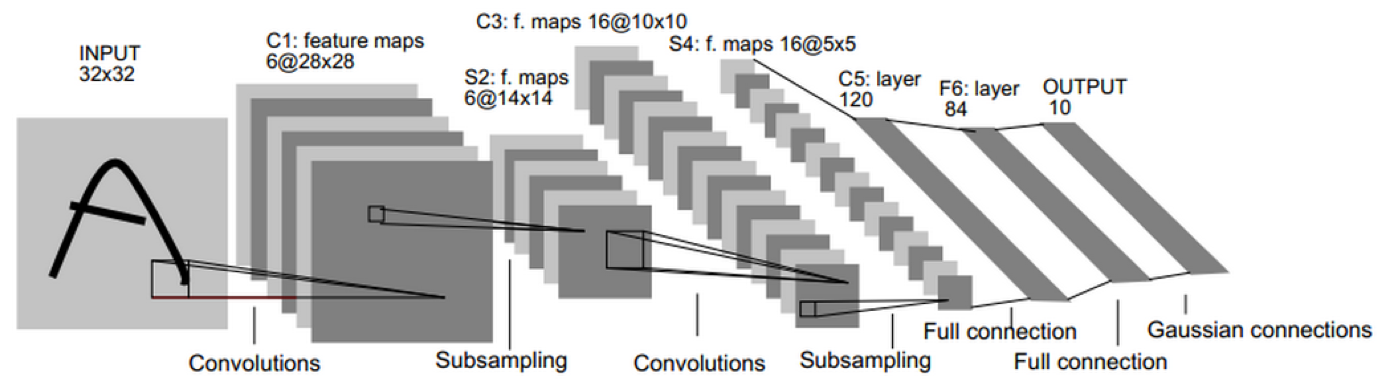

The input images will be cut into small pieces with overlapping. In this example, each image is cut into 28 $∗$  28 small pieces with the size of 5 $∗$  5.

After the sampling, each single piece will be fed into a small neural network. This piece can be used to decide the class of the input image. The output of this neural network will be a feature array (2d for gray image and 3d for colored image). The weight calculation will be same in this step to each single piece and that performs a convolution.

Upon completion of convolution, max pooling is used for subsampling. The feature array are compressed by picking the max value of the subsampling array and discarding the other values. 

The result of the max pooling can be the input of a next convolution layer, or can be the input of the full connection layer.

# 3. TensorFlow

TensorFlow is a useful library to reduce the time of complex math calculation. It can be used to do complex mathematical process, mathine learning, GPU support, etc.

## 1. Tensor

TensorFlow useds tensor as its data block. Dimension and type will need to be specified for the tensor. We will be able to define 1d, 2d, 3d tensors.

In [122]:
# Needed to show the value
sess = tf.Session()

In [123]:
# Define 2d tensor
arr = np.array([(1,2,3),(4,5,6)])
t = tf.convert_to_tensor(arr, tf.float32)
print(sess.run(t))

[[1. 2. 3.]
 [4. 5. 6.]]


We will be able to do calculation on arrays with TensorFlow.

In [124]:
# Calculation between tensors
arr2 = np.array([(10,20,30),(40,50,60)])
tsum = tf.add(arr, arr2)
print(sess.run(tsum))

[[11 22 33]
 [44 55 66]]


In [165]:
# Calculation between tensors
tmul = tf.multiply(arr, arr2)
print(sess.run(tmul))

[[ 10  40  90]
 [160 250 360]]


## 2. Image Processing

For image processing, we will need to import a 3d array into TensorFlow. Lat's see how to do that.

In [157]:
import matplotlib.image as img
nm = "Picture1.png"
exp_img = img.imread(nm)
print(exp_img.ndim)
print(exp_img.shape)

3
(381, 1379, 4)


We can see from the result of the image that of its shape and the channel of its colors.

Next, we are going to use TensorFlow to crop the image. The following is a image before the processing.

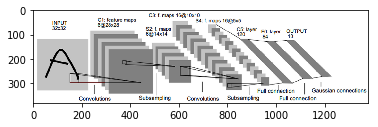

In [131]:
import matplotlib.pyplot as plt
plt.imshow(exp_img)
plt.show()

Using the following commands can crop the image to the size 200$*$200 from the upper left corner.

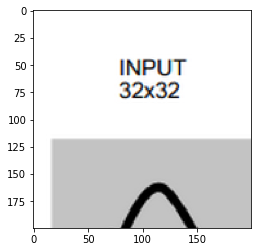

In [162]:
cropped = tf.image.crop_to_bounding_box(
    image=exp_img,
    offset_height=0,
    offset_width=0,
    target_height=200,
    target_width=200
)
plt.imshow(sess.run(cropped))
plt.show()

## 3. Modeling

Estimator is a high-level TensorFlow API. We set up models within the Estimator, train the model, check the model's metrics and do the prediction. TensorFlow provides some [pre-setup classifier estimators](https://www.tensorflow.org/get_started/premade_estimators), including DNN classifier and linear classifier. We can also define our own Estimator. 

There are three steps in using the Estimator:
- Build the model or choose a pre-made model
- Train the model
- Evaluate the model
- Use the model to do the prediction

The following paragraph will build a customized model using those steps.

# 4. Facial Expression Recognition on TensorFlow

After proposed by Paul Ekman, Facial Action Coding System (FACS) became an important tool in the research of facial expression recognition. Datasets created based on FACS, including Ekman FACS, Cohn-Kanade, etc. are still in wide use now.

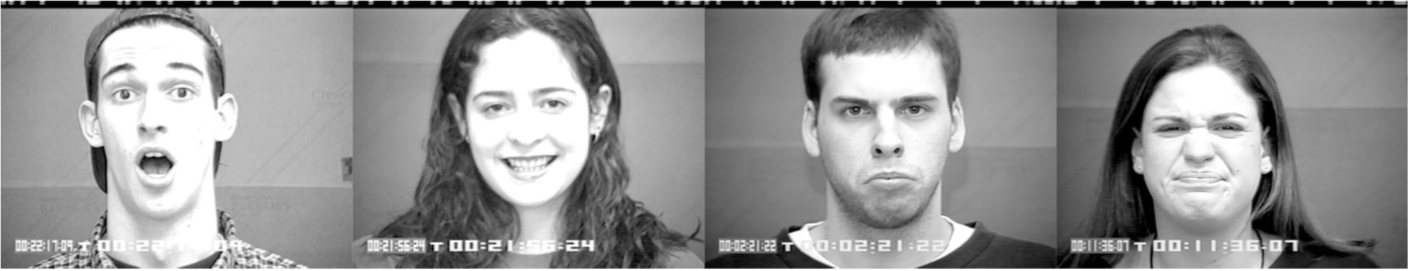

This article will use the Cohn-Kanade (CK in short) data. The image above shows the raw data. However, we are using a pre-processed dataset based on the CK data.

[The input file](https://drive.google.com/file/d/1r-O5T9duU9SE3G7hYsdDYVrIY-JLI9HW/view?usp=sharing) provided is pre-processed with matlab. The matrix 'dict' contains the labels, 'train_x' contains the images(in uint8, on the scale of 0-255). The size of total data point is 2057.

The images are removed parts other than the face, performed illumination compensation, and normalized to a 64$*$64 size.

Instead of loading the image directly, I'm using scipy to import the mat file.

In [111]:
# Import the images
imgfile = 'cmu_uint8_all_or.mat'
data = scipy.io.loadmat(imgfile)
size=data['train_x'].shape[2]

Let's look at one of the images. 

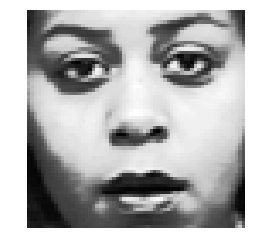

In [112]:
import matplotlib.pyplot as plt
plt.imshow(data['train_x'][:,:,0])
plt.set_cmap('gray')
plt.axis('off')
plt.show()

The labels represents: angry(1), disgust(2), fear(3), happy(4), sad(5), surprise(6). The following gives the label of previous image.

In [109]:
data['dict'][0][2]

6

In the next part, we will build up a model with the data above. There will be 2 convolution layers and 2 max pooling layers. The input size of the images are 64 $*$ 64. 

For the input layer, we can reshape the input to make every image of the input is 64$*$64 (or any other size we need). We specify the color channel as 1. The batchsize will be assigned later so we put -1 here.

For the convolution layer, we are using `relu` as the activation function for CNN. We are using 5$*$5 as the size of the kernel.

We can also add bias to the convolution layer and the pooling layer. `tf.layers.conv2d` and `tf.layers.max_pooling2d` both have the parameters. We just need to specify the bias vector and then assign them in the parameters when calling the functions.

Dropout rate will be used to increase the weight of some important features and decrease the weight of irrelevant features. 

In logits layer we set the units to 6 because we have 6 classes.


In [125]:
def cnn_model_fn(features, labels, mode):
	# input
	input_layer = tf.reshape(features["x"], [-1, 64, 64, 1])

	# conv1
	conv1 = tf.layers.conv2d(
	  inputs=input_layer,
	  filters=32,
	  kernel_size=[5, 5],
	  padding="same",
	  activation=tf.nn.relu)

	# pool1
	pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

	# conv2
	conv2 = tf.layers.conv2d(
	  inputs=pool1,
	  filters=64,
	  kernel_size=[5, 5],
	  padding="same",
	  activation=tf.nn.relu)
    
	# pool2
	pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

	# full connection
	pool2_flat = tf.reshape(pool2, [-1, 16 * 16 * 64])
	dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    
	dropout = tf.layers.dropout(
	  inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

	# Logits 
	logits = tf.layers.dense(inputs=dropout, units=6)

	predictions = {
	  # generate prediction for test, train
	  "classes": tf.argmax(input=logits, axis=1),
	  "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
	}

	if mode == tf.estimator.ModeKeys.PREDICT:
		return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

	# calculate loss for training and estimation
	loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

	# use gradient descent optimizer. Set the learning rate to 0.001. 
    # Be sure to experiement on this parameter because sometimes 
    # the optimizer will be stuck in local optimization if the rate is too small.
	if mode == tf.estimator.ModeKeys.TRAIN:
		optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
		train_op = optimizer.minimize(
		    loss=loss,
		    global_step=tf.train.get_global_step())
		return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

	# Output the metrics
	eval_metric_ops = {
	  "accuracy": tf.metrics.accuracy(
	      labels=labels, 
          predictions=predictions["classes"]
      )
    }
    
	return tf.estimator.EstimatorSpec(
	  mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)



For the output metrics, we also have a wide choice, see docs [here](https://www.tensorflow.org/api_docs/python/tf/metrics). 

In [ ]:
# Output the metrics
eval_metric_ops = {
    "accuracy": tf.metrics.accuracy(
              labels=labels,
              predictions=predictions["classes"]
    ),
    "auc": tf.metrics.auc(
            labels=labels, 
            predictions=predictions["classes"]
    ),
    "recall": tf.metrics.recall(
            labels=labels, 
            predictions=predictions["classes"]
    )
}

Run the following cell to input the data, train the model and do the classification. The batch size is the number of images input into one calculation. 'None' for epoch number means that the training will stop when it reaches the step mentioned in the following training process.

In [128]:
def main(unused_argv):
	# Load training and eval data
	train_num=2000
	test_num=57

	test_idx=random.sample(range(size), test_num)
	train_idx=list(set(range(2057))-set(test_idx))

	train_data=np.asarray(data['train_x'][:,:,train_idx].transpose()/255, dtype=np.float32)
	train_labels=np.asarray((data['dict'][:,2][train_idx]-1).transpose(), dtype=np.int32)
	
	eval_data=np.asarray(data['train_x'][:,:,test_idx].transpose()/255, dtype=np.float32)
	eval_labels=np.asarray((data['dict'][:,2][test_idx]-1).transpose(), dtype=np.int32)

	# Create the Estimator
	classifier = tf.estimator.Estimator(
	  model_fn=cnn_model_fn, model_dir="/tmp/model")

# 	# Set up logging for predictions
# 	# Log the values in the "Softmax" tensor with label "probabilities"
# 	tensors_to_log = {"probabilities": "softmax_tensor"}
# 	logging_hook = tf.train.LoggingTensorHook(
# 	  tensors=tensors_to_log, every_n_iter=50)

	# Train the model
	train_input_fn = tf.estimator.inputs.numpy_input_fn(
	  x={"x": train_data},
	  y=train_labels,
	  batch_size=50,
	  num_epochs=None,
	  shuffle=True)
	classifier.train(
	  input_fn=train_input_fn,
	  steps=5000
#         ,hooks=[logging_hook]
    )

	# Evaluate the model and print results
	eval_input_fn = tf.estimator.inputs.numpy_input_fn(
	  x={"x": eval_data},
	  y=eval_labels,
	  num_epochs=1,
	  shuffle=False)
	eval_results = classifier.evaluate(input_fn=eval_input_fn)
	print(eval_results)


if __name__ == "__main__":
	tf.app.run()


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x18374345c0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model/model.ckpt-1
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2 into /tmp/model/model.ckpt.
INF

SystemExit: 

/Users/lawmichelle/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


The accuracy of this example is not satisfying. There are several reasons that may lead to the result. 
- The pre-processing of the data is not good enough. Some of the faces are not perfectly located.
- The model is not trained comprehensively. We can try some more steps in the training process.
- The face classifier only is not enough for the expression recognition. We can use a combined classifier to solve this problem. For example, we can locate the eye area and the month area. Run separate classifiers on separate areas and then combine the result to find the class of the certain image. 

As we have set up checkpoints while training, the models can be restored. For future research, we can reuse the models. See how to restore [here](https://www.tensorflow.org/get_started/checkpoints).